In [2]:
#dataset builder
%pip install python-binance
#%pip install pandas_ta #https://github.com/twopirllc/pandas-ta

from binance import Client
import numpy as np
import pandas as pd
import datetime as dt
from datetime import timedelta
#import pandapas_ta as ta
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

    #add api key/secret, a new api key/secret can be obtained from binance.us
api_data = pd.read_csv('api_key_secret.csv', index_col=0)
api_key = api_data.loc['key'][0]
api_secret  = api_data.loc['secret'][0]

  Using cached python_binance-1.0.19-py2.py3-none-any.whl (69 kB)
  Using cached dateparser-1.2.0-py2.py3-none-any.whl (294 kB)
  Using cached ujson-5.9.0-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (53 kB)
  Using cached websockets-12.0-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (130 kB)
  Using cached pycryptodome-3.19.0-cp35-abi3-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (2.1 MB)


In [3]:
      #functions used in dataset_builder not necessary to define within class.

def normalize_data(dataframe):
    'normalizes df passed'
    from sklearn.preprocessing import MinMaxScaler
    data = dataframe
    index, column_names = data.index, data.columns
    transformer = MinMaxScaler().fit(data)
    norm_data = transformer.transform(data)
    norm_data = pd.DataFrame(norm_data, columns=column_names, index=index)
    return norm_data

def convert_unix_timestamp(series):
    'converts unix timestamp series to datetime'
    return series.apply(lambda x: dt.datetime.fromtimestamp(x/1000))

def OHE_hours(datetime_series):
    'one hot encoding for the hours when passed datetime series'
    hours = pd.get_dummies(datetime_series.hour, drop_first=True)
    hours.set_index(datetime_series, inplace=True)
    hours.columns = ['1am','2am','3am','4am','5am','6am','7am','8am','9am','10am','11am','12pm','1pm','2pm','3pm','4pm','5pm','6pm','7pm','8pm','9pm','10pm','11pm']
    return hours

def sma_data(dataframe, window_size):
    'returns simple moving average data for df with respect to the provided window_size'
    sma_data = dataframe.rolling(window=window_size).mean().iloc[window_size - 1:]
    return sma_data

def macd_data(dataframe, span):
    'returns macd data for df'
    macd = dataframe.ewm(span=span[0], adjust=False, min_periods=span[0]).mean() - dataframe.ewm(span=span[1], adjust=False, min_periods=span[1]).mean()
    macd_signal = macd.ewm(span=span[2], adjust=False, min_periods=span[2]).mean()
    return macd, macd_signal


def rma(x, n):
  """Running moving average"""
  a = np.full_like(x, np.nan)
  a[n] = x[1:n+1].mean()
  for i in range(n+1, len(x)):
    a[i] = (a[i-1] * (n - 1) + x[i]) / n
  return a


def rsi_data(dataframe, length):

  rsi = pd.DataFrame()

  for x in dataframe.columns:
    df = pd.DataFrame(dataframe[x])

    df['change'] = df.diff()
    df['gain'] = df.change.mask(df.change < 0, 0.0)
    df['loss'] = -df.change.mask(df.change > 0, -0.0)
    df['avg_gain'] = rma(df.gain.to_numpy(), length)
    df['avg_loss'] = rma(df.loss.to_numpy(), length)

    df['rs'] = df.avg_gain / df.avg_loss
    df['rsi'] = 100 - (100 / (1 + df.rs))
    rsi = pd.concat([rsi, df['rsi']], axis=1)
  rsi.columns = dataframe.columns
  return rsi

In [4]:
class dataset_builder():
  'with the provided api key/secret data is collected and formed into a dataset with several Ta indicator options.'

  def __init__(self, api_key, api_secret, asset_type, assets, interval, start_date, end_date):
    '''
        initializing variables for later use

    Params:
      api_key:      (str) key aquired from binance.us to access data
      api_secret:   (str) secret to confirm account data for data collection
      asset_type:   ignore. never finished. leave as 'crypto'
      assets:       (list) assets to include in dataset
      interval:     (str) interval of candle strick data, must align with binance api
      start_date:   (str) beginning of dataset; must be in form YYYY-MM-DD HH:MM:SS
      end_date:     (str) end of dataset; must be in form YYYY-MM-DD HH:MM:SS
    '''
    self.api_key = api_key
    self.api_secret = api_secret
    self.asset_type = asset_type
    self.assets = assets
    self.interval = interval
    self.start_date = start_date
    self.end_date = end_date
    self.client = Client(self.api_key, self.api_secret, tld='us')
    self.price_df, self.volume_df = self.price_volume_data()

  def get_kline_data(self, asset):
    'get historical kline data for the passed asset and returns the (series)datetime, (series)open price, (series)volume'
    if self.asset_type=='crypto':
      kline_data = self.client.get_historical_klines(asset, self.interval, self.start_date, self.end_date)
      kline_data = pd.DataFrame(kline_data)
      index_date, asset_open, volume = convert_unix_timestamp(kline_data[0]), kline_data[1], kline_data[5]
    elif self.asset_type=='stock':  #stock portion not finished
      kline_data = yf.download(asset, start=self.start_date, end=self.end_date, interval=self.interval)
      kline_data = pd.DataFrame(kline_data)
      index_date, asset_open, volume = kline_data.index, kline_data['Open'], kline_data['Volume']
    return index_date, asset_open, volume

  def price_volume_data(self):
    ' returns the price and volume data to be used for price_data and signal_data'
    price_df = None
    volume_df = None
    date_index = None

    for asset in self.assets:
      if asset == self.assets[0]:
        date_index, price_df, volume_df = self.get_kline_data(asset)
      else:
        _ , asset_open, volume = self.get_kline_data(asset)
        price_df = pd.concat([price_df, asset_open], axis=1)
        volume_df = pd.concat([volume_df, volume], axis=1)

    price_df = pd.concat([date_index, price_df], axis=1)
    price_df.columns = ['datetime'] + self.assets
    price_df.set_index('datetime', inplace=True)

    volume_df = pd.concat([date_index, volume_df], axis=1)
    volume_df.columns = ['datetime'] + self.assets
    volume_df.set_index('datetime', inplace=True)
    return price_df.astype(float), volume_df.astype(float)

  def price_data(self):
    'returns price df'
    return self.price_df

  def signal_data(self, sma=None, macd=None, rsi=None, volume=False, normalize=False, hours=False):
    '''
      compiles data and constructs TA signals

    Params:
    * dont need to use all TA indicators if nothing is input they will be ignored *
      sma:        (list) simple moving averages periods to include
      macd:       (list) span of macd
      rsi:        (int) period to span for relative strength index
      volume:     (boolean) include volume or not
      normalize:  (boolean) whether to normalize data
      hours:      (boolean) whether to include hours OHE

    Returns:
      signals_df  (pandas dataframe) df of assets and entered TA indicators.
    '''
    signals_df = pd.DataFrame(index=self.price_df.index)
    index = signals_df.index

      #SMA DATA
    if sma==None:
      pass
    else:
      for length in sma:
        signals_df = pd.concat([signals_df, sma_data(dataframe=self.price_df, window_size=length).add_prefix(f'sma{length}_')], axis=1)

      #MACD DATA
    if macd==None:
      pass
    else:
      signals_df = pd.concat([signals_df, macd_data(dataframe=self.price_df, span=macd)[0].add_prefix('macd_')], axis=1)
      signals_df = pd.concat([signals_df, macd_data(dataframe=self.price_df, span=macd)[1].add_prefix('macd-sig_')], axis=1)

      #RSI DATA
    if rsi==None:
      pass
    else:
      signals_df = pd.concat([signals_df, rsi_data(dataframe=self.price_df, length=rsi).add_prefix(f'rsi{rsi}_')], axis=1)

      #VOLUME DATA
    if volume:
      signals_df = pd.concat([signals_df, self.volume_df.add_prefix('volume_')], axis=1)
    else:
      pass

      #NORMALIZE DATA
    if normalize:
      signals_df = normalize_data(signals_df)
    else:
      pass

      #ADD HOURS
    if hours:
      signals_df.index = index
      signals_df = pd.concat([signals_df, OHE_hours(signals_df.index)], axis=1)
    else:
      pass

    return signals_df


In [18]:
assets = ['BTCUSDT', 'ETHUSDT', 'SOLUSDT']
asset_type = 'crypto'
interval = '1m'
start_date = '2023-11-28 00:00:00'
end_date = '2023-11-29 00:00:00'

price_df = dataset_builder(api_key=api_key, api_secret=api_secret, asset_type=asset_type, assets=assets, interval=interval, start_date=start_date, end_date=end_date).price_data()
signals_df = dataset_builder(api_key=api_key, api_secret=api_secret, asset_type=asset_type, assets=assets, interval=interval, start_date=start_date, end_date=end_date).signal_data(sma=[5,10], macd=[12,26,9], rsi=14, volume=True, normalize=True, hours=True)

In [19]:
signals_df.columns

Index(['sma5_BTCUSDT', 'sma5_ETHUSDT', 'sma5_SOLUSDT', 'sma10_BTCUSDT',
       'sma10_ETHUSDT', 'sma10_SOLUSDT', 'macd_BTCUSDT', 'macd_ETHUSDT',
       'macd_SOLUSDT', 'macd-sig_BTCUSDT', 'macd-sig_ETHUSDT',
       'macd-sig_SOLUSDT', 'rsi14_BTCUSDT', 'rsi14_ETHUSDT', 'rsi14_SOLUSDT',
       'volume_BTCUSDT', 'volume_ETHUSDT', 'volume_SOLUSDT', '1am', '2am',
       '3am', '4am', '5am', '6am', '7am', '8am', '9am', '10am', '11am', '12pm',
       '1pm', '2pm', '3pm', '4pm', '5pm', '6pm', '7pm', '8pm', '9pm', '10pm',
       '11pm'],
      dtype='object')

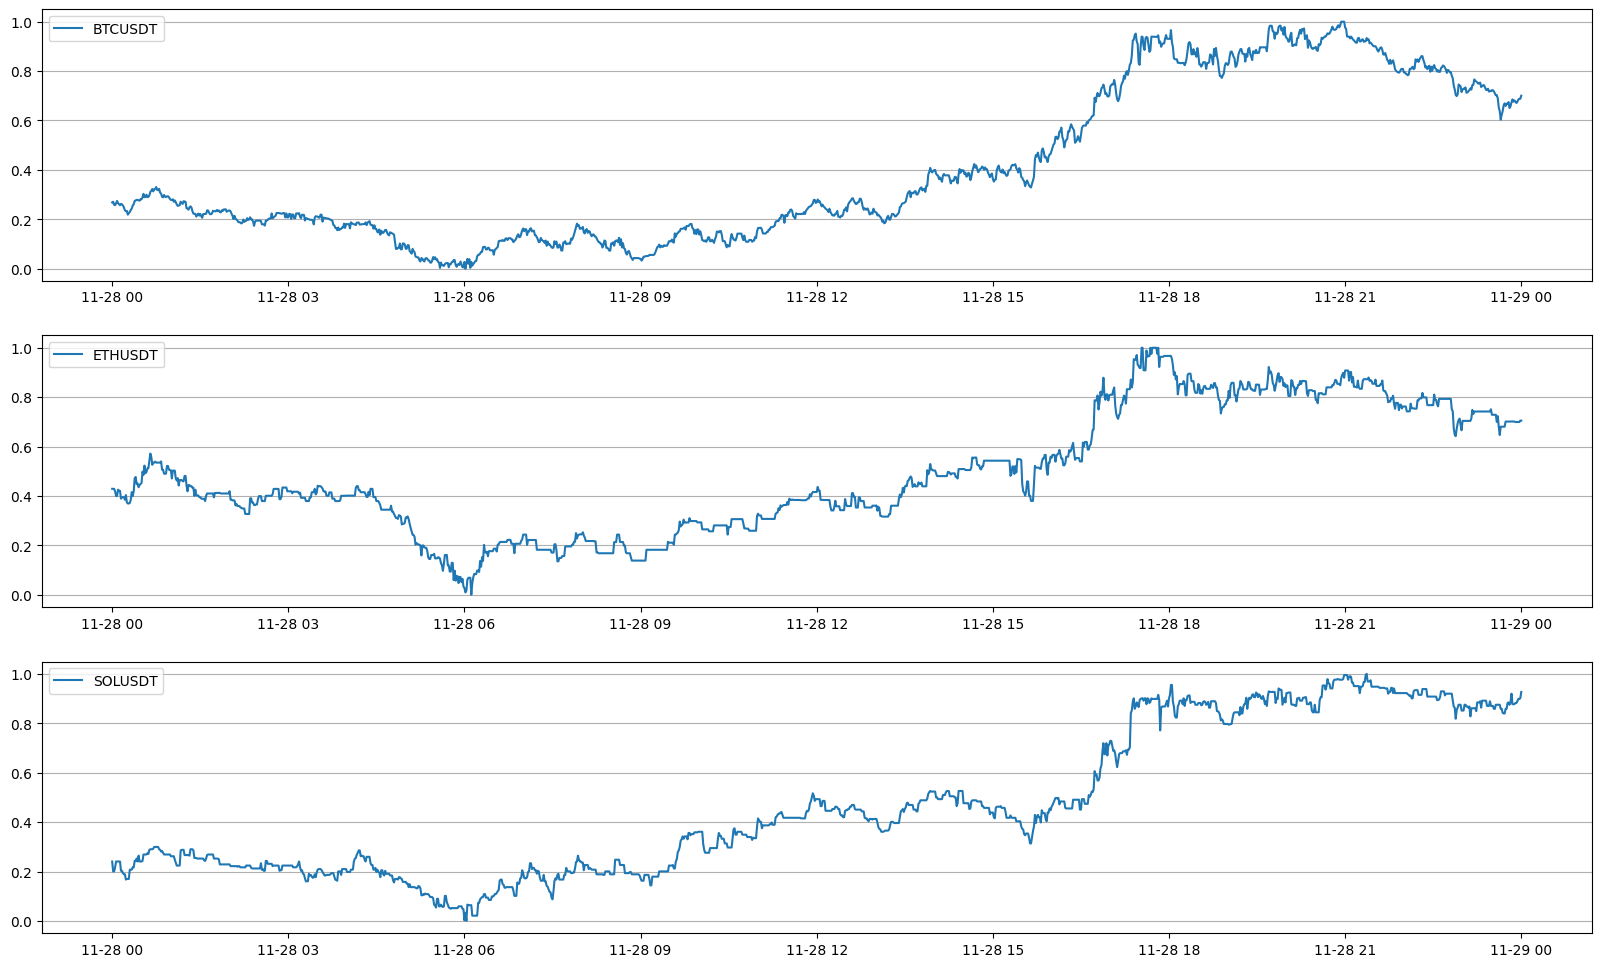

In [20]:
#plot of price_df

norm_price_df = normalize_data(price_df)

fig = plt.figure(figsize=(20,4*len(norm_price_df.columns)))
for index, asset in enumerate(assets):
  ax = plt.subplot2grid((len(norm_price_df.columns),1),(index,0))
  plt.plot(norm_price_df[asset], label=asset)
  plt.title('assets normalized')
  plt.grid(visible=True, which='major', axis='y')
  plt.legend(loc='upper left')
plt.show()

In [ ]:
    # save each dataset

from google.colab import files
signals_df.to_csv('signals_df.csv', encoding = 'utf-8-sig')
files.download('signals_df.csv')

from google.colab import files
price_df[33:].to_csv('price_df.csv', encoding = 'utf-8-sig')
files.download('price_df.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
signals_df[33:].head()

,sma5_BTCUSDT,sma5_ETHUSDT,sma5_SOLUSDT,sma10_BTCUSDT,sma10_ETHUSDT,sma10_SOLUSDT,macd_BTCUSDT,macd_ETHUSDT,macd_SOLUSDT,macd-sig_BTCUSDT,...,2pm,3pm,4pm,5pm,6pm,7pm,8pm,9pm,10pm,11pm
datetime,,,,,,,,,,,,,,,,,,,,,
2023-11-28 00:33:00,0.281462,0.465771,0.238095,0.275956,0.447835,0.223243,0.434507,0.560611,0.444501,0.422040,...,0,0,0,0,0,0,0,0,0,0
2023-11-28 00:34:00,0.283158,0.474708,0.243926,0.277371,0.449437,0.225975,0.436063,0.567357,0.456209,0.430915,...,0,0,0,0,0,0,0,0,0,0
2023-11-28 00:35:00,0.286922,0.483860,0.249757,0.279520,0.454573,0.227713,0.444757,0.573703,0.463770,0.440086,...,0,0,0,0,0,0,0,0,0,0
2023-11-28 00:36:00,0.287178,0.486460,0.256074,0.280703,0.460952,0.231189,0.441248,0.587137,0.472183,0.446587,...,0,0,0,0,0,0,0,0,0,0
2023-11-28 00:37:00,0.284670,0.492120,0.256560,0.282115,0.469071,0.231934,0.437949,0.596105,0.474885,0.451002,...,0,0,0,0,0,0,0,0,0,0


In [22]:
price_df[33:].head()

,BTCUSDT,ETHUSDT,SOLUSDT
datetime,,,
2023-11-28 00:33:00,37280.26,2035.93,55.26
2023-11-28 00:34:00,37280.54,2033.59,55.26
2023-11-28 00:35:00,37293.33,2033.94,55.26
2023-11-28 00:36:00,37280.26,2035.04,55.28
2023-11-28 00:37:00,37281.41,2035.15,55.27


In [ ]:
  # adjustments for lstm-forecasting, dataset_builder must be initialized.

In [93]:
# paramaters
lstm_asset = ['BTCUSDT']    #can only run a single asset for lstm model
lstm_interval = '1m'
lstm_start_date = '2023-11-28 00:00:00'
lstm_end_date = '2023-11-29 00:00:00'

In [94]:
# builds price/signals datasets and combines necessary components.
price_LSTM_df = dataset_builder(api_key=api_key, api_secret=api_secret, asset_type='crypto', assets=lstm_asset, interval=lstm_interval, start_date=lstm_start_date, end_date=lstm_end_date).price_data()
price_LSTM_df = price_LSTM_df[33:]
price_data = np.array(price_LSTM_df['BTCUSDT'])

signals_LSTM_df = dataset_builder(api_key=api_key, api_secret=api_secret, asset_type='crypto', assets=lstm_asset, interval=lstm_interval, start_date=lstm_start_date, end_date=lstm_end_date).signal_data(sma=[2,5,10], rsi=14, volume=True, normalize=True)
signals_LSTM_df = signals_LSTM_df[32:-1]
signals_LSTM_df['price'] = price_data
signals_LSTM_df


In [96]:
# saves dataset

from google.colab import files
signals_LSTM_df.to_csv('lstm_data.csv', encoding = 'utf-8-sig')
files.download('lstm_data.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>